# Retinal pyramid and addition of saccades


## 1. Using only the Laplacian pyramid

### 1.1. Initialization parameters & functions

Parameters :

In [1]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 1.61803
base_levels = 2 #downsampling/upsampling factor

N_batch = 4 #number of images 
pattern = 'i05june05_static_street_boston_p1010808'

In [2]:
n_sublevel = 2 #filters dictionnary, number of sublevels
n_azimuth = 12 #retinal transform characteristics 
n_theta = 12
n_phase = 2

Libraries :

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from SLIP import imread
from SLIP import Image as Image_SLIP
import time

from PIL import Image

In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [5]:
import imageio

### Log gabor functions :
Creating the filters

#### Cette cellule est inutile

In [6]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}                 #log-Gabor parameters
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [7]:
from PYramid import local_filter
from torch.nn.functional import interpolate 
from PYramid import cropped_pyramid
from PYramid import inverse_pyramid

lg shape= 32 32


Le format du paramŠtre est incorrect - "data".


Tensor shape= torch.Size([1, 3, 768, 1024])


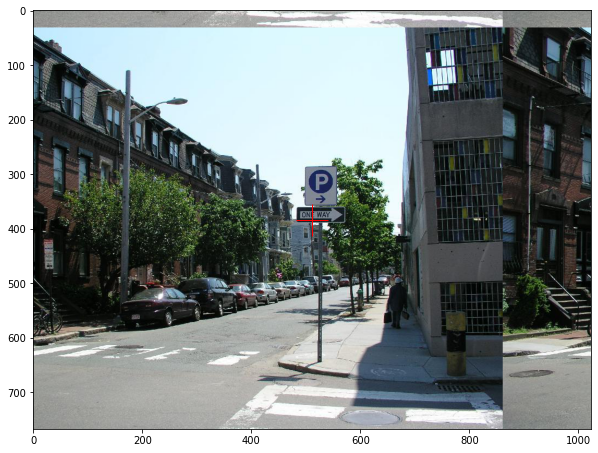

In [8]:
%ls ../data #list of images stored in file data
img_orig = Image.open('../data/i05june05_static_street_boston_p1010764.jpeg')
ds = 1
if ds>1: img_orig = img_orig[::ds, ::ds]
img_orig = np.roll(img_orig, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom

N_X, N_Y = img_orig.shape[0], img_orig.shape[1]
pe = {'N_X': N_X, 'N_Y': N_Y, 'do_mask': False} 

im = Image_SLIP(pe) 
img_orig_mean=img_orig.mean()
#img_orig = img_orig -img_orig.mean() #substracting the image's mean to each element
#img_orig *= im.mask[:,:,np.newaxis] #adding an oval mask  
img_tens = torch.Tensor(img_orig[None,...]).permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #converting to a tensor format, image's size stored in img_tens.shape[-2:]

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

### 4.2. Using torch to build up a Laplacian pyramid

In [9]:
from torch.nn.functional import interpolate 

Applying on the central crop of $32\times32$ and building the pyramid :

In [10]:
print(img_tens.shape)
img_crop = cropped_pyramid(img_tens, color=True, do_mask=True,verbose=True)[0]

torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 384, 512]) , shape= torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 192, 256]) , shape= torch.Size([1, 3, 384, 512])
Tensor shape= torch.Size([1, 3, 96, 128]) , shape= torch.Size([1, 3, 192, 256])
Tensor shape= torch.Size([1, 3, 48, 64]) , shape= torch.Size([1, 3, 96, 128])
Tensor shape= torch.Size([1, 3, 24, 32]) , shape= torch.Size([1, 3, 48, 64])
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


In [11]:
from PYramid import get_K

In [12]:
K = get_K(verbose=True)

i_sublevel, sf_0, radius 0 0.3606737602222408 5.333333333333333
i_sublevel, sf_0, radius 1 0.2550348616491973 7.542472332656507
K shape= torch.Size([32, 32, 2, 12, 12, 2])
K min max= tensor(-1.) tensor(1.)


### 4.4. Applying the filters to the cropped images

In [13]:
from PYramid import log_gabor_transform

In [14]:
print('img_crop shape=', img_crop.shape) #cropped image tensor shape

log_gabor_coeffs = log_gabor_transform(img_crop, K) # applying K filters to the cropped image (convolution)

print('log_gabor_coeffs shape=', log_gabor_coeffs.shape)

img_crop shape= torch.Size([1, 6, 3, 32, 32])
log_gabor_coeffs shape= torch.Size([1, 6, 3, 2, 12, 12, 2])


Displaying central crops from successive residual images

Tensor shape= torch.Size([1, 6, 3, 32, 32])


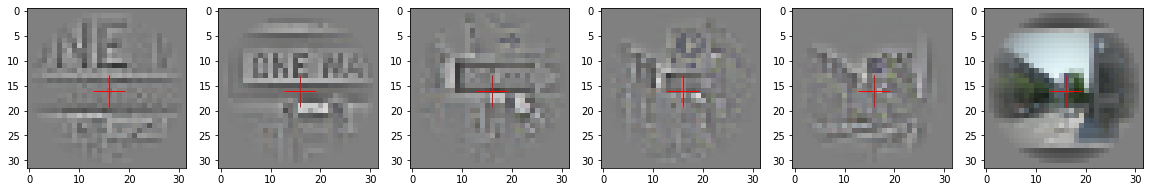

In [16]:
n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_crop.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape) 

Inversing K filters

In [17]:
from PYramid import get_K_inv

Reconstruction layer by layer from cropped central images:

In [18]:
from PYramid import inverse_gabor

In [19]:
K_inv = get_K_inv(K)

img_rec=inverse_gabor(log_gabor_coeffs, K_inv)

Filter tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([576, 1024])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])


Displaying central crops from successive residual images (cf pyramid)

Tensor shape= torch.Size([1, 6, 3, 32, 32])


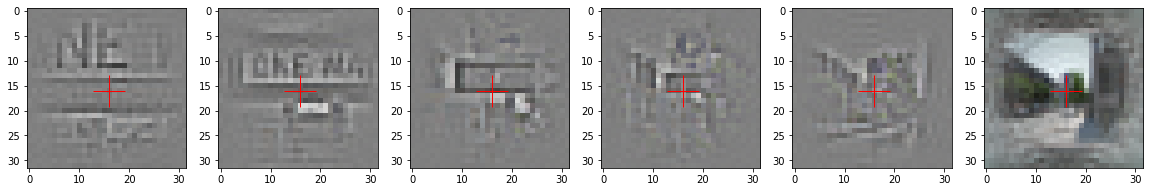

In [20]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_rec.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_rec.shape) 

### 4.5. Inverse pyramid from the coefficients

In [21]:
img_rec = inverse_pyramid(img_rec, color=True)

#### Plotting reconstructed image

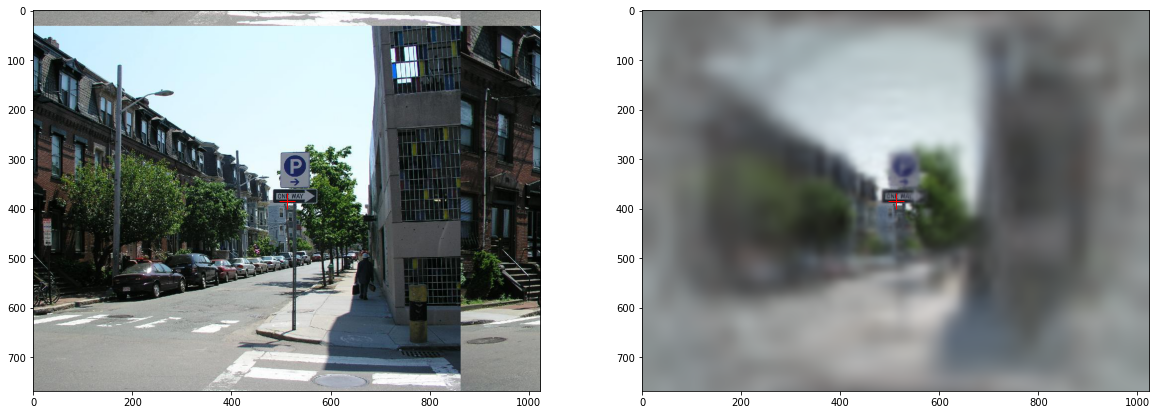

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens.permute(0,2,3,1), img_rec.detach().permute(0,2,3,1)]):
    ax.imshow(img[0, ...].numpy().astype('uint'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

In [25]:
import numpy as np
import urllib
import time
from PIL import Image
from skimage.metrics import structural_similarity
import os
import sys


from pytorch_msssim import ssim, ms_ssim


In [26]:
if __name__ == '__main__':
    print("Downloading test image...")
    
    img = Image.open('../data/i05june05_static_street_boston_p1010764.jpeg')
    img = np.array(img).astype(np.float32)

    img_batch = []
    img_noise_batch = []
    single_image_ssim = []
    N_repeat = 100
    print("====> Single Image")
    print("Repeat %d times"%(N_repeat))
    # params = torch.nn.Parameter( torch.ones(img.shape[2], img.shape[0], img.shape[1]), requires_grad=True ) # C, H, W
    for sigma in range(0, 101, 10):
        noise = sigma * np.random.rand(*img.shape)
        img_noise = (img + noise).astype(np.float32).clip(0,255)
        
        begin = time.time()
        for _ in range(N_repeat):
            ssim_skimage = structural_similarity(img, img_noise, win_size=11, multichannel=True,
                                    sigma=1.5, data_range=255, use_sample_covariance=False, gaussian_weights=True)
        time_skimage = (time.time()-begin) / N_repeat

        img_torch = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)  # 1, C, H, W
        img_noise_torch = torch.from_numpy(img_noise).unsqueeze(0).permute(0, 3, 1, 2)

        img_batch.append(img_torch)
        img_noise_batch.append(img_noise_torch)

        begin = time.time()
        for _ in range(N_repeat):
            ssim_torch = ssim(img_noise_torch, img_torch, win_size=11, data_range=255)
        time_torch = (time.time()-begin) / N_repeat

        ssim_torch = ssim_torch.numpy()
        single_image_ssim.append(ssim_torch)

        print("sigma=%f ssim_skimage=%f (%f ms) ssim_torch=%f (%f ms)" % (
            sigma, ssim_skimage, time_skimage*1000, ssim_torch, time_torch*1000))

        #Image.fromarray( img_noise.astype('uint8') ).save('simga_%d_ssim_%.4f.png'%(sigma, ssim_torch.item()))
        assert (np.allclose(ssim_torch, ssim_skimage, atol=5e-4))

    print("Pass")

    print("====> Batch")
    img_batch = torch.cat(img_batch, dim=0)
    img_noise_batch = torch.cat(img_noise_batch, dim=0)
    ssim_batch = ssim(img_noise_batch, img_batch, win_size=11,
                      size_average=False, data_range=255)
    assert np.allclose(ssim_batch, single_image_ssim, atol=5e-4)
    print("Pass")



====> Single Image
Repeat 100 times
sigma=0.000000 ssim_skimage=1.000000 (1322.927885 ms) ssim_torch=1.000000 (1074.157910 ms)
sigma=10.000000 ssim_skimage=0.948371 (1319.471219 ms) ssim_torch=0.948369 (1127.331979 ms)
sigma=20.000000 ssim_skimage=0.849141 (1516.775458 ms) ssim_torch=0.849137 (797.112081 ms)
sigma=30.000000 ssim_skimage=0.749404 (1129.340034 ms) ssim_torch=0.749399 (950.535562 ms)
sigma=40.000000 ssim_skimage=0.666804 (1128.192692 ms) ssim_torch=0.666799 (853.390489 ms)
sigma=50.000000 ssim_skimage=0.601040 (1053.720963 ms) ssim_torch=0.601036 (891.386123 ms)
sigma=60.000000 ssim_skimage=0.547151 (1055.508859 ms) ssim_torch=0.547147 (816.134012 ms)
sigma=70.000000 ssim_skimage=0.503049 (1222.751982 ms) ssim_torch=0.503046 (1130.155220 ms)
sigma=80.000000 ssim_skimage=0.465998 (1243.318875 ms) ssim_torch=0.465995 (808.261955 ms)
sigma=90.000000 ssim_skimage=0.434903 (1063.351243 ms) ssim_torch=0.434901 (810.838170 ms)


KeyboardInterrupt: 

GDN

In [27]:
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function
import math

# https://arxiv.org/pdf/1611.01704.pdf

class LowerBound(Function):
    @staticmethod
    def forward(ctx, inputs, bound):
        ctx.save_for_backward(inputs, inputs.new_ones(1)*bound )
        return inputs.clamp(min=bound)

    @staticmethod
    def backward(ctx, grad_output):
        inputs, bound = ctx.saved_tensors

        pass_through_1 = (inputs >= bound)
        pass_through_2 = (grad_output < 0)

        pass_through = (pass_through_1 | pass_through_2)
        return pass_through.type(grad_output.dtype) * grad_output, None
    
class GDN(nn.Module):
    def __init__(self, 
                num_features,
                inverse=False,
                gamma_init=.1,
                beta_bound=1e-6,
                gamma_bound=0.0,
                reparam_offset=2**-18,
            ):
        super(GDN, self).__init__()
        self._inverse = inverse
        self.num_features = num_features
        self.reparam_offset = reparam_offset
        self.pedestal = self.reparam_offset**2

        beta_init = torch.sqrt( torch.ones(num_features, dtype=torch.float) + self.pedestal )
        gama_init = torch.sqrt( torch.full( (num_features, num_features), fill_value=gamma_init, dtype=torch.float ) 
                                        * torch.eye(num_features, dtype=torch.float) + self.pedestal )

        self.beta = nn.Parameter( beta_init )
        self.gamma = nn.Parameter( gama_init )

        self.beta_bound = (beta_bound + self.pedestal) ** 0.5
        self.gamma_bound = (gamma_bound + self.pedestal) ** 0.5

    def _reparam(self, var, bound):
        var = LowerBound.apply( var, bound )
        return (var**2) - self.pedestal

    def forward(self, x):
        gamma = self._reparam( self.gamma, self.gamma_bound ).view(self.num_features, self.num_features, 1,1) # expand to (C, C, 1, 1)
        beta = self._reparam( self.beta, self.beta_bound )
        norm_pool = F.conv2d( x**2, gamma, bias=beta, stride=1, padding=0)
        norm_pool = torch.sqrt(norm_pool)

        if self._inverse:
            norm_pool = x * norm_pool 
        else:
            norm_pool = x / norm_pool  
        return norm_pool

Auto encodeur

In [28]:
import torch.nn.functional as F
import math

# https://arxiv.org/pdf/1611.01704.pdf 
# A simplfied version without quantization
class AutoEncoder(nn.Module):
    def __init__(self, C=128, M=128, in_chan=3, out_chan=3):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(C=C, M=M, in_chan=in_chan)
        self.decoder = Decoder(C=C, M=M, out_chan=out_chan)

    def forward(self, x, **kargs):
        code = self.encoder(x)
        out = self.decoder(code)
        return out

class Encoder(nn.Module):
    """ Encoder
    """
    def __init__(self, C=32, M=128, in_chan=3):
        super(Encoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=M, kernel_size=5, stride=2, padding=2, bias=False),
            GDN(M),

            nn.Conv2d(in_channels=M, out_channels=M, kernel_size=5, stride=2, padding=2, bias=False),
            GDN(M),

            nn.Conv2d(in_channels=M, out_channels=M, kernel_size=5, stride=2, padding=2, bias=False),
            GDN(M),

            nn.Conv2d(in_channels=M, out_channels=C, kernel_size=5, stride=2, padding=2, bias=False)
        )

    def forward(self, x):
        return self.enc(x)

class Decoder(nn.Module):
    """ Decoder
    """
    def __init__(self, C=32, M=128, out_chan=3):
        super(Decoder, self).__init__()
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=C, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            GDN(M, inverse=True),

            nn.ConvTranspose2d(in_channels=M, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            GDN(M, inverse=True),

            nn.ConvTranspose2d(in_channels=M, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            GDN(M, inverse=True),

            nn.ConvTranspose2d(in_channels=M, out_channels=out_chan, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
        )
    
    def forward(self, q):
        return torch.sigmoid( self.dec(q) )

Function

In [29]:
import torch._C as _C
import torch.utils.hooks as hooks
from torch._six import with_metaclass
import functools
import warnings
from collections import OrderedDict
from typing import Any


class _ContextMethodMixin(object):

    def save_for_backward(self, *tensors):
        r"""Saves given tensors for a future call to :func:`~Function.backward`.

        **This should be called at most once, and only from inside the**
        :func:`forward` **method.**

        Later, saved tensors can be accessed through the :attr:`saved_tensors`
        attribute. Before returning them to the user, a check is made to ensure
        they weren't used in any in-place operation that modified their content.

        Arguments can also be ``None``.
        """
        self.to_save = tensors

    def mark_dirty(self, *args):
        r"""Marks given tensors as modified in an in-place operation.

        **This should be called at most once, only from inside the**
        :func:`forward` **method, and all arguments should be inputs.**

        Every tensor that's been modified in-place in a call to :func:`forward`
        should be given to this function, to ensure correctness of our checks.
        It doesn't matter whether the function is called before or after
        modification.
        """
        self.dirty_tensors = args

    def mark_shared_storage(self, *pairs):
        warnings.warn(
            'mark_shared_storage is deprecated. '
            'Tensors with shared storages are automatically tracked. Note '
            'that calls to `set_()` are not tracked')

    def mark_non_differentiable(self, *args):
        r"""Marks outputs as non-differentiable.

        **This should be called at most once, only from inside the**
        :func:`forward` **method, and all arguments should be outputs.**

        This will mark outputs as not requiring gradients, increasing the
        efficiency of backward computation. You still need to accept a gradient
        for each output in :meth:`~Function.backward`, but it's always going to
        be a zero tensor with the same shape as the shape of a corresponding
        output.

        This is used e.g. for indices returned from a max :class:`Function`.
        """
        self.non_differentiable = args


class _HookMixin(object):

    @staticmethod
    def _register_hook(backward_hooks, hook):
        if backward_hooks is None:
            backward_hooks = OrderedDict()
        handle = hooks.RemovableHandle(backward_hooks)
        backward_hooks[handle.id] = hook
        return backward_hooks, handle


class BackwardCFunction(_C._FunctionBase, _ContextMethodMixin, _HookMixin):
    _is_legacy = False

    def apply(self, *args):
        return self._forward_cls.backward(self, *args)


class FunctionMeta(type):
    """Function metaclass.

    This metaclass sets up the following properties:
        _is_legacy: True if forward is not defined as a static method.
        _backward_cls: The Function class corresponding to the differentiated
            version of this function (which is generated on the fly by this
            metaclass).
    """

    def __init__(cls, name, bases, attrs):
        for super_cls in cls.mro():
            forward = super_cls.__dict__.get('forward')
            if forward is not None:
                has_static_forward = isinstance(forward, staticmethod) or isinstance(forward, classmethod)
                break

        cls._is_legacy = not has_static_forward

        # old-style functions
        if not has_static_forward:
            return super(FunctionMeta, cls).__init__(name, bases, attrs)

        backward_fn = type(name + 'Backward', (BackwardCFunction,), {'_forward_cls': cls})
        cls._backward_cls = backward_fn

        return super(FunctionMeta, cls).__init__(name, bases, attrs)


class Function(with_metaclass(FunctionMeta, _C._FunctionBase, _ContextMethodMixin, _HookMixin)):
    r"""Records operation history and defines formulas for differentiating ops.

    See the Note on extending the autograd engine for more details on how to use
    this class: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd

    Every operation performed on :class:`Tensor` s creates a new function
    object, that performs the computation, and records that it happened.
    The history is retained in the form of a DAG of functions, with edges
    denoting data dependencies (``input <- output``). Then, when backward is
    called, the graph is processed in the topological ordering, by calling
    :func:`backward` methods of each :class:`Function` object, and passing
    returned gradients on to next :class:`Function` s.

    Normally, the only way users interact with functions is by creating
    subclasses and defining new operations. This is a recommended way of
    extending torch.autograd.

    Examples::

        >>> class Exp(Function):
        >>>
        >>>     @staticmethod
        >>>     def forward(ctx, i):
        >>>         result = i.exp()
        >>>         ctx.save_for_backward(result)
        >>>         return result
        >>>
        >>>     @staticmethod
        >>>     def backward(ctx, grad_output):
        >>>         result, = ctx.saved_tensors
        >>>         return grad_output * result
        >>>
        >>> #Use it by calling the apply method:
        >>> output = Exp.apply(input)
    """

    def __call__(self, *args, **kwargs):
        raise RuntimeError(
            "Legacy autograd function with non-static forward method is deprecated. "
            "Please use new-style autograd function with static forward method. "
            "(Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)")

    # for the tracer
    is_traceable = False

    @staticmethod
    def forward(ctx: Any, *args: Any, **kwargs: Any) -> Any:
        r"""Performs the operation.

        This function is to be overridden by all subclasses.

        It must accept a context ctx as the first argument, followed by any
        number of arguments (tensors or other types).

        The context can be used to store tensors that can be then retrieved
        during the backward pass.
        """
        raise NotImplementedError("You must implement the forward function for custom"
                                  " autograd.Function.")

    @staticmethod
    def backward(ctx: Any, *grad_outputs: Any) -> Any:
        r"""Defines a formula for differentiating the operation.

        This function is to be overridden by all subclasses.

        It must accept a context :attr:`ctx` as the first argument, followed by
        as many outputs did :func:`forward` return, and it should return as many
        tensors, as there were inputs to :func:`forward`. Each argument is the
        gradient w.r.t the given output, and each returned value should be the
        gradient w.r.t. the corresponding input.

        The context can be used to retrieve tensors saved during the forward
        pass. It also has an attribute :attr:`ctx.needs_input_grad` as a tuple
        of booleans representing whether each input needs gradient. E.g.,
        :func:`backward` will have ``ctx.needs_input_grad[0] = True`` if the
        first input to :func:`forward` needs gradient computated w.r.t. the
        output.
        """
        raise NotImplementedError("You must implement the backward function for custom"
                                  " autograd.Function.")


def once_differentiable(fn):

    @functools.wraps(fn)
    def wrapper(ctx, *args):
        with torch.no_grad():
            outputs = fn(ctx, *args)

        if not torch.is_grad_enabled():
            return outputs

        # If any of the inputs have requires_grad=True, we force the outputs
        # to have requires_grad=True but point to a grad_fn which throws an
        # error message during (double) back-propagation.
        # XXX: this is only an approximation of requires_grad - there's no way
        # to figure out if fn didn't use ctx.saved_tensors and as a result
        # some Tensors might require grad, even if no args do.
        # Unfortunately, this leads to unexpected error messages ("no nodes
        # require computing gradients"), but I don't have a better idea.
        # These functions would raise an error in backward anyway.
        requires_grad = any(isinstance(arg, torch.Tensor) and arg.requires_grad
                            for arg in args)
        if not requires_grad:
            return outputs

        if not isinstance(outputs, tuple):
            outputs = (outputs,)

        err_fn = torch._C._functions.DelayedError(
            b"trying to differentiate twice a function that was marked"
            b"with @once_differentiable", len(outputs))

        # Create aliases of each output that has requires_grad=True. We need
        # at least one of the inputs to err_fn to require grad so that the
        # output will have a grad_fn.
        def fake_requires_grad(var):
            if var is not None:
                var = var.detach()
                var.requires_grad = True
            return var

        return err_fn(*[fake_requires_grad(v) for v in outputs])
    return wrapper


def traceable(fn_cls):
    r"""Marks Function as traceable for the JIT.

    Traceable functions have additional restrictions - they can't pass any
    data-dependent values to backward (e.g. Prod passes the output, which makes
    it non-traceable), and their backward should be implemented entirely in terms
    of operations on autograd Tensors in all cases.

    DON'T USE THIS DECORATOR. IT IS FOR INTERNAL USE ONLY AND SHOULD BE HANDLED WITH
    CARE (or can give incorrect results otherwise).
    """
    fn_cls.is_traceable = True
    return fn_cls


class InplaceFunction(Function):

    def __init__(self, inplace=False):
        super(InplaceFunction, self).__init__()
        self.inplace = inplace


def _nested_map(condition, fn, condition_msg=None):
    def _map(obj):
        if condition(obj):
            return fn(obj)
        elif obj is None:
            return None
        elif isinstance(obj, (list, tuple)):
            mapped = (_map(x) for x in obj)
            if hasattr(obj, '_fields'):
                # obj is namedtuple
                return type(obj)(*mapped)
            return type(obj)(mapped)
        elif isinstance(obj, dict):
            return {x : _map(obj[x]) for x in obj}
        else:
            raise ValueError("Auto nesting doesn't know how to process "
                             "an input object of type " + torch.typename(obj) +
                             (". Accepted types: " + condition_msg +
                              ", or lists/tuples of them"
                              if condition_msg else ""))

    return _map


def _jit_unwrap_structured(obj):
    if hasattr(obj, "_jit_unwrap"):
        return obj._jit_unwrap()
    return obj


def _iter_filter(condition, allow_unknown=False, condition_msg=None,
                 conversion=None):
    def _iter(obj):
        if conversion is not None:
            obj = conversion(obj)
        if condition(obj):
            yield obj
        elif obj is None:
            return
        elif isinstance(obj, (list, tuple)):
            for o in obj:
                for var in _iter(o):
                    yield var
        elif isinstance(obj, dict):
            # We only accept primitive key types, so we needn't inspect them
            for o in obj.values():
                for var in _iter(o):
                    yield var
        elif allow_unknown:
            yield obj
        else:
            raise ValueError("Auto nesting doesn't know how to process "
                             "an input object of type " + torch.typename(obj) +
                             (". Accepted types: " + condition_msg +
                              ", or lists/tuples of them"
                              if condition_msg else ""))

    return _iter


def _unflatten(input, proto):
    # unflatten a list or tuple input into a nested list/tuple structure
    # specified by proto
    def unflatten_helper(input, proto):
        res = []
        if hasattr(proto, "_jit_wrap"):
            return proto._jit_wrap(input)
        if not isinstance(proto, (list, tuple)):
            return input[0], input[1:]
        for e in proto:
            if e is None:
                res.append(e)
            else:
                res_e, input = unflatten_helper(input, e)
                res.append(res_e)
        return type(proto)(res), input

    return unflatten_helper(input, proto)[0]


_iter_jit_values = _iter_filter(lambda o: o is None or isinstance(o, torch._C.Value),
                                condition_msg="jit's Values or None")
_iter_tensors = _iter_filter(lambda x: isinstance(x, torch.Tensor), condition_msg="Tensors",
                             conversion=_jit_unwrap_structured)
_iter_tensors_permissive = _iter_filter(lambda x: isinstance(x, torch.Tensor),
                                        allow_unknown=True,
                                        condition_msg="Tensors (permissive)")
_iter_None_tensors = _iter_filter(lambda o: o is None or isinstance(o, torch.Tensor),
                                  condition_msg="Tensors or None")
_map_tensor_data = _nested_map(lambda x: isinstance(x, torch.Tensor), lambda o: o.data,
                               condition_msg="Tensors")


class NestedIOFunction(Function):
    # The 'type: ignore' statements are needed here because these functions are declared as '@staticmethod' in the
    # superclass (Function) but are instance methods here, which mypy reports as incompatible.

    def _do_forward(self, *input):
        self._nested_input = input
        flat_input = tuple(_iter_tensors(input))
        flat_output = super(NestedIOFunction, self)._do_forward(*flat_input)
        nested_output = self._nested_output
        nested_tensors = _unflatten(flat_output, self._nested_output)
        return nested_tensors

    def _do_backward(self, gradients, retain_variables):
        self.retain_variables = retain_variables
        result = super(NestedIOFunction, self)._do_backward(gradients, retain_variables)
        if not retain_variables:
            del self._nested_output
            del self._to_save_nested
        return result

    def backward(self, *gradients: Any) -> Any:
        nested_gradients = _unflatten(gradients, self._nested_output)
        result = self.backward_extended(*nested_gradients)
        return tuple(_iter_None_tensors(result))

    __call__ = _do_forward

    def forward(self, *args: Any) -> Any:
        nested_tensors = _map_tensor_data(self._nested_input)
        result = self.forward_extended(*nested_tensors)
        del self._nested_input
        self._nested_output = result
        return tuple(_iter_tensors(result))

    def save_for_backward(self, *args: Any) -> None:
        self.to_save = tuple(_iter_tensors(args))
        self._to_save_nested = args

    @property
    def saved_tensors(self):
        flat_tensors = super(NestedIOFunction, self).saved_tensors
        return _unflatten(flat_tensors, self._to_save_nested)

    def mark_dirty(self, *args: Any, **kwargs: Any) -> None:
        self.dirty_tensors = tuple(_iter_tensors((args, kwargs)))

    def mark_non_differentiable(self, *args: Any, **kwargs: Any) -> None:
        self.non_differentiable = tuple(_iter_tensors((args, kwargs)))

    def forward_extended(self, *input: Any) -> None:
        raise NotImplementedError

    def backward_extended(self, *grad_output: Any) -> None:
        raise NotImplementedError